Google ColaboratoryにてGPUを使用する

---



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


データセットの読み込み

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=80, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


画像の表示

In [3]:
def im_convert(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  npimg = np.transpose(npimg, (1, 2, 0))

  return npimg

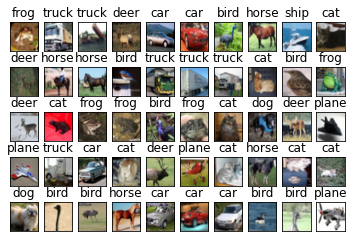

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

for i in range(5):
  for j in range(10):
    index = i * 10 + j
    image=  im_convert(images[index])
    plt.subplot(5, 10, index +1)
    plt.imshow(image)
    plt.title(classes[int(labels[index])])
    plt.tick_params(labelbottom=False, labelright=False, labelleft=False,
                    labeltop=False, bottom=False, right=False, left=False, top=False)
    
plt.show()

ネットワークの構築

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [6]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

学習

In [7]:
epochs = 15
history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

for e in range(epochs):
  train_loss = 0.0
  train_correct = 0.0
  train_total = 0.0
  for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _,  preds = torch.max(outputs, 1)
    train_total += labels.size(0)
    train_correct += torch.sum(preds == labels)

# epoch中のテスト  
  test_correct = 0.0
  test_total = 0.0
  with torch.no_grad():
      for inputs, labels in testloader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          test_total += labels.size(0)
          test_correct += (predicted == labels).sum().item()

  # 記録
  history['train_loss'].append(train_loss / train_total)
  history['train_acc'].append(train_correct/ train_total)
  history['test_acc'].append(test_correct / test_total)

  # 表示
  print('epoch *', (e+1))
  print('traing_loss: {:.4f}'.format(train_loss / train_total))
  print('train_acc:{:.4f}, test_acc:{:.4f}'.format(train_correct / train_total, test_correct / test_total))


epoch * 1
traing_loss: 0.0230
train_acc:0.1010, test_acc:0.1031
epoch * 2
traing_loss: 0.0230
train_acc:0.1398, test_acc:0.1757
epoch * 3
traing_loss: 0.0224
train_acc:0.2154, test_acc:0.2425
epoch * 4
traing_loss: 0.0205
train_acc:0.2703, test_acc:0.2908
epoch * 5
traing_loss: 0.0193
train_acc:0.3119, test_acc:0.3391
epoch * 6
traing_loss: 0.0182
train_acc:0.3493, test_acc:0.3766
epoch * 7
traing_loss: 0.0170
train_acc:0.3871, test_acc:0.4073
epoch * 8
traing_loss: 0.0161
train_acc:0.4155, test_acc:0.4306
epoch * 9
traing_loss: 0.0155
train_acc:0.4375, test_acc:0.4495
epoch * 10
traing_loss: 0.0151
train_acc:0.4555, test_acc:0.4661
epoch * 11
traing_loss: 0.0146
train_acc:0.4733, test_acc:0.4787
epoch * 12
traing_loss: 0.0143
train_acc:0.4879, test_acc:0.4900
epoch * 13
traing_loss: 0.0139
train_acc:0.5020, test_acc:0.5012
epoch * 14
traing_loss: 0.0136
train_acc:0.5135, test_acc:0.5147
epoch * 15
traing_loss: 0.0133
train_acc:0.5258, test_acc:0.5227


グラフ

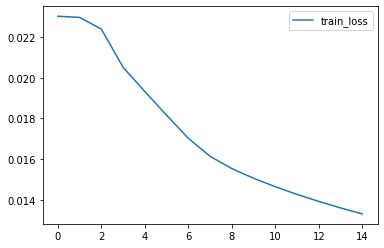

In [8]:
plt.plot(history['train_loss'], label='train_loss')
plt.legend()

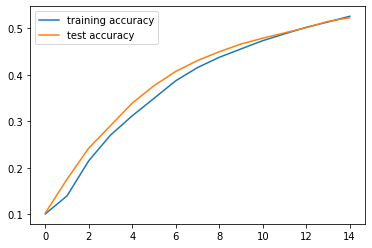

In [9]:
plt.plot(history['train_acc'], label='training accuracy')
plt.plot(history['test_acc'], label='test accuracy')
plt.legend()

推論

Predection (True_labels)


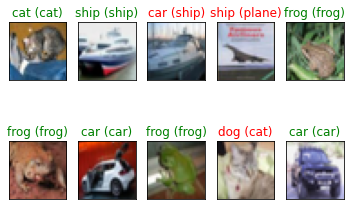

In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()
input = images.to(device)
output = net(input)
_, preds = torch.max(output, 1)

for i in range(2):
  for j in range(5):
    index = i * 5 + j
    image=  im_convert(images[index])
    plt.subplot(2, 5, index +1)
    plt.imshow(image)
    plt.title("{} ({})".format(str(classes[preds[index].item()]), str(classes[labels[index].item()])), 
              color=("green" if preds[index]==labels[index] else "red"))
    plt.tick_params(labelbottom=False, labelright=False, labelleft=False,
                    labeltop=False, bottom=False, right=False, left=False, top=False)
    
print("Predection (True_labels)")
plt.show()